In [12]:
## jif_main ##
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import statsmodels.api as sm # to build a LOWESS model
lowess = sm.nonparametric.lowess

import numpy as np
import matplotlib.dates as mdates
from matplotlib import gridspec
import matplotlib as mpl
import cartopy.io.shapereader as shpreader
import cartopy.io.img_tiles as cimgt
import matplotlib
import netCDF4
import math
from datetime import datetime, timedelta
import os

def error_lowess_filter(error, speed, time, frac=None):
        print('Calculating errors and lowess function')
        error_val = np.delete(error, np.argwhere(np.isnan(speed.values)))
        time_val = np.delete(time, np.argwhere(np.isnan(speed.values)))
        speed_val = np.delete(speed.values, np.argwhere(np.isnan(speed.values)))
        lowess_val = lowess(speed_val, time_val, frac=frac)

        return error_val, speed_val, time_val, lowess_val

def winter_anom(speed_clean, winter_mean, time, frac=None):
        anom = ((speed_clean - winter_mean.values) / winter_mean.values)  * 100.0
        lowess_val = lowess(anom, time, frac=frac)

        return anom, lowess_val

def masked_dates_land(dataset, year_start, year_end, melt_start, melt_end):
    frac=1/5
    dataset.index = pd.to_datetime(dataset.index)
    winter_mask = (dataset.index > pd.to_datetime('2021-11-06')) & (dataset.index < pd.to_datetime('2022-04-24'))
    year_mask = (dataset.index > year_start) & (dataset.index < year_end)
    melt_mask = (dataset.index > melt_start) & (dataset.index < melt_end)
    premelt_mask = (dataset.index > pd.to_datetime('2022-08-01')) & (dataset.index < pd.to_datetime('2022-08-20')) # 2022-10-01 to 2022-10-16

    year_ds = dataset.loc[year_mask]
    winter_ds = dataset.loc[winter_mask]

    year_ds['anom'] = (year_ds['S'].values / winter_ds['S'].median()) * 100 # percentage of winter median
    
    lowess_s = sm.nonparametric.lowess(year_ds['S'].values, year_ds.index.values, frac=frac)
    year_ds['lowess'] = lowess_s[:,1]

    lowess_anom = sm.nonparametric.lowess(year_ds['anom'].values, year_ds.index.values, frac=frac)
    year_ds['lowess_anom'] = lowess_anom[:,1]
    year_ds['winter_median'] = winter_ds['S'].median()

    melt_mean = dataset['S'].loc[melt_mask].mean()
    premelt_mean = dataset['S'].loc[premelt_mask].mean()
    acceleration = ((melt_mean - premelt_mean) / premelt_mean) * 100

    year_ds['acceleration'] = acceleration

    return year_ds

def masked_dates_mtg(dataset, year_start, year_end, melt_start, melt_end):
    frac=1/5
    dataset.index = pd.to_datetime(dataset.index)
    # winter_mask = (dataset.index > pd.to_datetime('2021-11-06')) & (dataset.index < pd.to_datetime('2022-04-24'))
    year_mask = (dataset.index > year_start) & (dataset.index < year_end)
    melt_mask = (dataset.index > melt_start) & (dataset.index < melt_end)
    premelt_mask = (dataset.index > pd.to_datetime('2022-08-01')) & (dataset.index < pd.to_datetime('2022-08-20'))

    year_ds = dataset.loc[year_mask]
    
    lowess_s = sm.nonparametric.lowess(year_ds['S'].values, year_ds.index.values, frac=frac)
    year_ds['lowess'] = lowess_s[:,1]

    melt_mean = dataset['S'].loc[melt_mask].mean()
    premelt_mean = dataset['S'].loc[premelt_mask].mean()
    acceleration = ((melt_mean - premelt_mean) / premelt_mean) * 100
    print(acceleration, melt_mean, premelt_mean)

    year_ds['acceleration'] = acceleration

    return year_ds

def combine_error(array):
    return math.sqrt(sum([i**2 for i in array])/(len(array)**2))

data_dir = 'C:/Users/s1834371/Documents/PhD/melt22/GrIS_late-season-melt-event/data/'

In [13]:
IS_ROI1 = pd.read_csv(data_dir + 'velocity/IS_ROI-1_velocity_timeseries.csv', index_col=0) 
KAN_L_ROI = pd.read_csv(data_dir + 'velocity/KAN_L_ROI_velocity_timeseries.csv', index_col=0)
RUSSELL_ROI2 = pd.read_csv(data_dir + 'velocity/RUSSELL_ROI-2_velocity_timeseries.csv', index_col=0)
NORTH_NUNATAK_ROI3 = pd.read_csv(data_dir + 'velocity/NORTH_NUNATAK_ROI-3_velocity_timeseries.csv', index_col=0)
SOUTH_NUNATAK_ROI4 = pd.read_csv(data_dir + 'velocity/SOUTH_NUNATAK_ROI-4_velocity_timeseries.csv', index_col=0)
UNNAMED_SOUTH_ROI5 = pd.read_csv(data_dir + 'velocity/UNNAMED_SOUTH_ROI-5_velocity_timeseries.csv', index_col=0)

AS_ROI = pd.read_csv(data_dir + 'velocity/AS_ROI_timeseries.csv', index_col=0)
KNS_ROI = pd.read_csv(data_dir + 'velocity/KNS_ROI_timeseries.csv', index_col=0)

In [14]:
melt_start = pd.to_datetime('2022-08-21') # 2022-10-01
melt_end = pd.to_datetime('2022-09-14') # 2022-10-28

year_start = pd.to_datetime('2022-05-01')
year_end = pd.to_datetime('2022-11-15')

In [15]:
IS_ROI1 = masked_dates_land(IS_ROI1, year_start, year_end, melt_start, melt_end)
KAN_L_ROI = masked_dates_land(KAN_L_ROI, year_start, year_end, melt_start, melt_end)
RUSSELL_ROI2 = masked_dates_land(RUSSELL_ROI2, year_start, year_end, melt_start, melt_end)
NORTH_NUNATAK_ROI3 = masked_dates_land(NORTH_NUNATAK_ROI3, year_start, year_end, melt_start, melt_end)
SOUTH_NUNATAK_ROI4 = masked_dates_land(SOUTH_NUNATAK_ROI4, year_start, year_end, melt_start, melt_end)
UNNAMED_SOUTH_ROI5 = masked_dates_land(UNNAMED_SOUTH_ROI5, year_start, year_end, melt_start, melt_end)


year_start = pd.to_datetime('2022-05-10')
year_end = pd.to_datetime('2022-10-15')
AS_ROI = masked_dates_mtg(AS_ROI, year_start, year_end, melt_start, melt_end)
KNS_ROI = masked_dates_mtg(KNS_ROI, year_start, year_end, melt_start, melt_end)

10.351613719642588 415.6534652709961 376.6627883911133
2.4742346599631566 2986.022705078125 2913.9253540039062


C:\Users\s1834371\AppData\Local\Temp\ipykernel_13724\2201993650.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_ds['anom'] = (year_ds['S'].values / winter_ds['S'].median()) * 100 # percentage of winter median
C:\Users\s1834371\AppData\Local\Temp\ipykernel_13724\2201993650.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_ds['lowess'] = lowess_s[:,1]
C:\Users\s1834371\AppData\Local\Temp\ipykernel_13724\2201993650.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [16]:
kanl_velocity = pd.read_csv(data_dir + 'velocity/KANL_ice_velocity_010122-101122_3day_err.csv', index_col=0)
kanl_velocity['time'] = kanl_velocity['time'].str.strip("[']")
kanl_velocity['time'] = pd.to_datetime(kanl_velocity['time'].values)
kanl_velocity = kanl_velocity.set_index('time')
kanl_velocity_rsamp = kanl_velocity.resample('3D').mean()
year_mask = (kanl_velocity_rsamp.index > pd.to_datetime('2022-05-01')) & (kanl_velocity_rsamp.index < pd.to_datetime('2022-11-15'))
kanl_velocity_rsamp = kanl_velocity_rsamp.loc[year_mask]

kanl_velo_time = kanl_velocity_rsamp.index#.values
kanl_gps_speed = kanl_velocity_rsamp['ice_velocity'].values #* 365
y_hat_kanl_gps = lowess(kanl_gps_speed, kanl_velo_time, frac=1/24)

kanl_error_rsamp = kanl_velocity.resample('3D').apply(combine_error) 
year_mask = (kanl_error_rsamp.index > pd.to_datetime('2022-05-01')) & (kanl_error_rsamp.index < pd.to_datetime('2022-11-15'))
kanl_error_rsamp = kanl_error_rsamp.loc[year_mask]
kanl_error = kanl_error_rsamp['velocity_error'].values

melt_start_gps = pd.to_datetime('2022-08-30') # 2022-10-01
melt_end_gps = pd.to_datetime('2022-09-04') # 2022-10-28

melt_mask = (kanl_velocity_rsamp.index > melt_start_gps) & (kanl_velocity_rsamp.index < melt_end_gps)
premelt_mask = (kanl_velocity_rsamp.index > pd.to_datetime('2022-08-01')) & (kanl_velocity_rsamp.index < pd.to_datetime('2022-08-20'))
#premelt_mask = (kanl_velocity_rsamp.index > pd.to_datetime('2022-10-01')) & (kanl_velocity_rsamp.index < pd.to_datetime('2022-10-16'))

melt_mean = kanl_velocity_rsamp['ice_velocity'].loc[melt_mask].mean()
premelt_mean = kanl_velocity_rsamp['ice_velocity'].loc[premelt_mask].mean()
kan_l_acceleration = ((melt_mean - premelt_mean) / premelt_mean) * 100

print('ACCELERATION')
print(kan_l_acceleration)

ACCELERATION
80.95188779222983


ACCELERATION
78.94402169750101


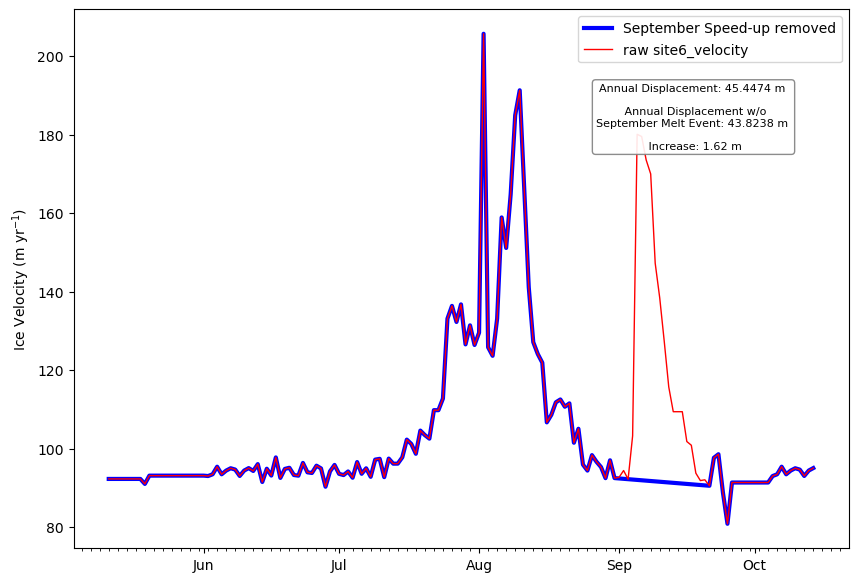

In [18]:
######### Site 6 velocity #############
site6_velocity = pd.read_csv(data_dir + 'velocity/site6_velocity_24h.csv')
site6_velocity['time'] = pd.to_datetime(site6_velocity['time'].values, dayfirst=True)
site6_velocity = site6_velocity.set_index('time')

winter_mask = (site6_velocity.index > pd.to_datetime('2021-11-01')) & (site6_velocity.index < pd.to_datetime('2022-04-01'))
winter_median_site6 = site6_velocity['v_24h'].loc[winter_mask].median()

year_mask = (site6_velocity.index > pd.to_datetime(year_start)) & (site6_velocity.index < pd.to_datetime(year_end))
site6_velocity = site6_velocity.loc[year_mask]

site6_velocity['daily_disp'] = site6_velocity['v_24h']/365 # making it into metres per day, daily displacement

annual_displacement = site6_velocity['daily_disp'].sum()

#----------------------------------------------
nomelt_vel = site6_velocity[(site6_velocity.index < '2022-09-01') | (site6_velocity.index > '2022-09-20')] # removing high discharge rates from melt event
nomelt_vel = nomelt_vel.resample('D').interpolate()

annual_displacement_nomelt = nomelt_vel['daily_disp'].sum()
increase_disp = annual_displacement - annual_displacement_nomelt

###################################
melt_start_gps = pd.to_datetime('2022-09-04') # 2022-10-01
melt_end_gps = pd.to_datetime('2022-09-07') # 2022-10-28
premelt_mask = (site6_velocity.index > pd.to_datetime('2022-08-20')) & (site6_velocity.index < pd.to_datetime('2022-08-28'))

melt_start_gps2 = pd.to_datetime('2022-10-21') # 2022-10-01
melt_end_gps2 = pd.to_datetime('2022-10-25') # 2022-10-28
premelt_mask2 = (site6_velocity.index > pd.to_datetime('2022-10-01')) & (site6_velocity.index < pd.to_datetime('2022-10-16'))

melt_mask = (site6_velocity.index > melt_start_gps) & (site6_velocity.index < melt_end_gps)

melt_mean = site6_velocity['v_24h'].loc[melt_mask].mean()
premelt_mean = site6_velocity['v_24h'].loc[premelt_mask].mean()
site6_acceleration = ((melt_mean - premelt_mean) / premelt_mean) * 100

print('ACCELERATION')
print(site6_acceleration)

##################################
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(nomelt_vel.index, nomelt_vel['v_24h'], color='blue', label='September Speed-up removed', linewidth=3.0)
ax.plot(site6_velocity.index, site6_velocity['v_24h'], color='red', linewidth=1.0, label='raw site6_velocity')
ax.set_ylabel('Ice Velocity (m yr$^{-1}$)')

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
text_str = 'Annual Displacement: %.4f m \n\n Annual Displacement w/o\nSeptember Melt Event: %.4f m \n\n Increase: %.2f m' % (annual_displacement, annual_displacement_nomelt, increase_disp)
ax.text(0.8, 0.8, text_str, transform=ax.transAxes, ha="center", va="center", size=8, bbox=bbox_props)

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=2))
myFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax.legend()

In [19]:
cosipy_data = xr.open_dataset(data_dir + 'KAN_L_cosipy_output_20090101-20221129.nc', engine='netcdf4')
year_mask = (cosipy_data['time'] > pd.to_datetime('2022-01-01')) & (cosipy_data['time'] < pd.to_datetime('2022-11-29'))

surfm = cosipy_data['surfM'].loc[year_mask]
surfm = surfm.mean(dim=['lon', 'lat'])
surfm = surfm.resample(time='1D').sum('time') # sum total daily melt
time_cosipy = pd.to_datetime(surfm['time'].values)

T2 = cosipy_data['T2'].loc[year_mask]
T2 = T2.mean(dim=['lon', 'lat'])
T2 = T2.resample(time='1D').mean('time')

T2_hist =  cosipy_data['T2'].mean(dim=['lon', 'lat']) - 273.15 # average spatially, convert to celcius

surfM_historic_raw =  cosipy_data['surfM'].mean(dim=['lon', 'lat']) # average spatially
surfM_historic_raw = surfM_historic_raw.resample(time='1D').sum('time') # sum total daily melt
surfM_historic = surfM_historic_raw.to_dataframe() # convert to pandas dataframe

surfM_historic = surfM_historic.groupby([surfM_historic.index.day, surfM_historic.index.month], as_index=False, sort=False).mean() # calculate yearly daily average
surfM_historic = surfM_historic.rolling(30, center=True).mean() # apply rolling mean of 30 days
surfM_historic = surfM_historic.drop(0)
surfM_historic.index = pd.date_range(start='01-01-2022', end='12-31-2022', freq='1D')

In [ ]:
tick_fontsize = 8
label_fontsize = 8
title_fontsize = 8
mpl.rcParams['font.family'] = 'Roboto'
plt.rcParams['axes.linewidth'] = 0.8
plt.rc('xtick', labelsize=tick_fontsize)
plt.rc('ytick', labelsize=tick_fontsize)
plt.rc('axes', labelsize=label_fontsize)
plt.rc('axes', titlesize=title_fontsize)
plt.rc('legend', fontsize=label_fontsize)    # legend fontsize
plt.rc('figure', titlesize=title_fontsize)  # fontsize of the figure title
plt.rc('axes', labelpad=1.5)
plt.rcParams['ytick.major.pad']='-0.2'
plt.rcParams['ytick.major.size'] = '1'
plt.rcParams['axes.facecolor'] = 'None'
plt.rcParams['savefig.facecolor']='w'
bbox_props = dict(boxstyle="round", fc="w", ec="0.2", alpha=0.2)

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=4, hspace=0.18, wspace=0.25)



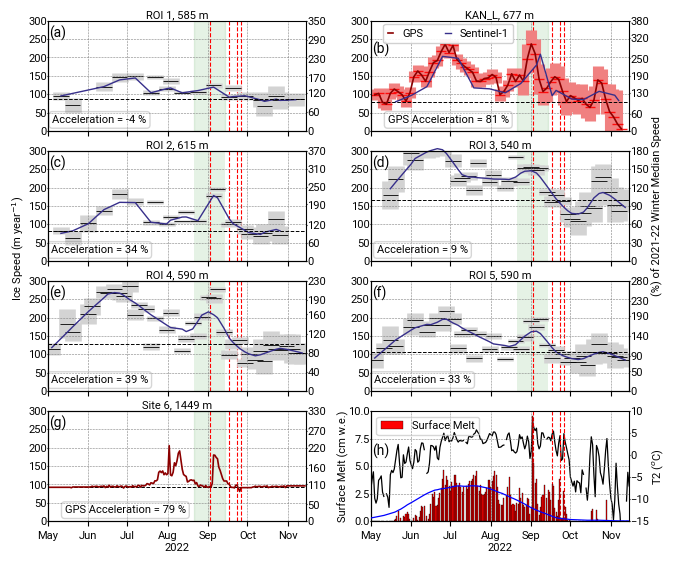

In [37]:
tick_fontsize = 8
label_fontsize = 8
title_fontsize = 8
mpl.rcParams['font.family'] = 'Roboto'
plt.rcParams['axes.linewidth'] = 0.8
plt.rc('xtick', labelsize=tick_fontsize)
plt.rc('ytick', labelsize=tick_fontsize)
plt.rc('axes', labelsize=label_fontsize)
plt.rc('axes', titlesize=title_fontsize)
plt.rc('legend', fontsize=label_fontsize)    # legend fontsize
plt.rc('figure', titlesize=title_fontsize)  # fontsize of the figure title
plt.rc('axes', labelpad=1.5)
plt.rcParams['ytick.major.pad']='-0.2'
plt.rcParams['ytick.major.size'] = '1'
plt.rcParams['axes.facecolor'] = 'None'
plt.rcParams['savefig.facecolor']='w'
bbox_props = dict(boxstyle="round", fc="w", ec="0.2", alpha=0.2)

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2, nrows=4, hspace=0.18, wspace=0.25)

############### ROI 1 #################################################
ax = fig.add_subplot(spec[0])
ax.set_facecolor('none')

#plot_historic(ax, IS_hist, IS_hist_dates)
ax.errorbar(IS_ROI1.index, IS_ROI1['S'], IS_ROI1['STD'], ls='none', ecolor='lightgrey', elinewidth=12, zorder=-4)
ax.errorbar(IS_ROI1.index, IS_ROI1['S'], xerr = timedelta(days=6), ecolor='black', elinewidth=0.6, ls='none', zorder=-2)
ax.plot(IS_ROI1.index, IS_ROI1['lowess'], color='#372F8B', linewidth=1.0, zorder=2, clip_on=False)
ax.axvspan(melt_start, melt_end, color='g', alpha=0.1, zorder=-6)

ax.axhline(IS_ROI1.winter_median.values[0], color='k', linestyle='--', linewidth=0.7)

yticks = [0, 50, 100, 150, 200, 250, 300]
ax.set_yticks(yticks)
ax.set_xlim(year_start, year_end)
ax.set_ylim(yticks[0], 300)

majorFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xticklabels([])
ax.set_title('ROI 1, 585 m', y=0.95)

ax.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.8, linestyle='--', zorder=-5)

# Show the tick labels
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.set_tick_params(labelbottom=False)
ax.tick_params(axis='x', which='major', pad=-2)

ax.spines[['right']].set_visible(False)
ax.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)

axb = ax.twinx()
yticks_b = [int(round((i/IS_ROI1['winter_median'].values[0])*100,-1)) for i in yticks]

axb.set_yticks(yticks_b)
axb.set_ylim(yticks_b[0],  yticks_b[-1])
axb.spines[['top']].set_visible(False)
axb.set_zorder(1)
#ax.text(0.9, 0.84, "ROI 1, 585 m", transform=ax.transAxes, ha="center", va="center", size=8, bbox=bbox_props)

textstr = 'Acceleration = %.f %%' % IS_ROI1['acceleration'].values[0]
ax.text(0.2, 0.1, textstr, transform=ax.transAxes, ha="center", va="center", size=8, bbox=bbox_props)
ax.text(0.005, 0.85, '(a)', transform=ax.transAxes, fontsize=10)



############### KAN_L #######################################################################################################
ax0 = fig.add_subplot(spec[1])
ax0.set_facecolor('none')

ax0.errorbar(kanl_velo_time, kanl_gps_speed, kanl_error, ls='none', ecolor='lightcoral', alpha=1.0, elinewidth=8, zorder=2)
ax0.errorbar(kanl_velo_time, kanl_gps_speed, xerr = timedelta(days=4), ecolor='red', alpha=0.9, elinewidth=1.0, ls='none', zorder=2)
ax0.plot(kanl_velo_time, y_hat_kanl_gps[:,1], color='darkred', alpha=1.0, linewidth=1.2, zorder=3, clip_on=False, label='GPS')
ax0.axvspan(melt_start, melt_end, color='g', alpha=0.1, zorder=-6)

ax0.plot(KAN_L_ROI.index, KAN_L_ROI['lowess'], color='#372F8B', linewidth=1.0, zorder=4, clip_on=False, label='Sentinel-1')

ax0.legend(loc='upper center', fontsize=8, fancybox=True, framealpha=0.9, facecolor='w', bbox_to_anchor=[0.3, 1.02], ncol=2, handlelength=0.5)

yticks = [0, 50, 100, 150, 200, 250, 300]
ax0.set_yticks(yticks)
ax0.set_xlim(year_start, year_end)
ax0.set_ylim(yticks[0], 300)

majorFmt = mdates.DateFormatter('%b')
ax0.xaxis.set_major_formatter(majorFmt)
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax0.set_xticklabels([])
ax0.set_title('KAN_L, 677 m', y=0.95)


ax0.spines[['right']].set_visible(False)
ax0.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax0.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax0.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax0.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax0.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax0.axhline(KAN_L_ROI.winter_median.values[0], color='k', linestyle='--', linewidth=0.7)

axb = ax0.twinx()
yticks_b = [int(round((i/KAN_L_ROI['winter_median'].values[0])*100,-1)) for i in yticks] # convert to percentage of winter media

axb.set_yticks(yticks_b)
axb.set_ylim(yticks_b[0],  yticks_b[-1])
axb.spines[['top']].set_visible(False)
axb.set_zorder(1)
#ax0.text(0.9, 0.84, "KAN_L, 677 m", transform=ax0.transAxes, ha="center", va="center", size=8, bbox=bbox_props)

textstr = 'GPS Acceleration = %.f %%' % kan_l_acceleration
ax0.text(0.3, 0.1, textstr, transform=ax0.transAxes, ha="center", va="center", size=8, bbox=bbox_props)
ax0.text(0.005, 0.7, '(b)', transform=ax0.transAxes, fontsize=10)

############### ROI 2 #######################################################################################################
ax1 = fig.add_subplot(spec[2])
ax1.set_facecolor('none')

#plot_historic(ax1, RUSS_hist, RUSS_hist_dates)
ax1.errorbar(RUSSELL_ROI2.index, RUSSELL_ROI2['S'], RUSSELL_ROI2['STD'], ls='none', ecolor='lightgrey', elinewidth=12, zorder=-4)
ax1.errorbar(RUSSELL_ROI2.index, RUSSELL_ROI2['S'], xerr = timedelta(days=6), ecolor='black', elinewidth=0.6, ls='none', zorder=-2)
ax1.plot(RUSSELL_ROI2.index, RUSSELL_ROI2['lowess'], color='#372F8B', linewidth=1.0, zorder=2, clip_on=False)
ax1.axvspan(melt_start, melt_end, facecolor='g', alpha=0.1, zorder=-6)

ax1.axhline(RUSSELL_ROI2.winter_median.values[0], color='k', linestyle='--', linewidth=0.7)

yticks = [0, 50, 100, 150, 200, 250, 300]
ax1.set_yticks(yticks)
ax1.set_xlim(year_start, year_end)
ax1.set_ylim(yticks[0], 300)

majorFmt = mdates.DateFormatter('%b')
ax1.xaxis.set_major_formatter(majorFmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.set_xticklabels([])
ax1.set_title('ROI 2, 615 m', y=0.95)


ax1.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax1.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax1.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax1.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax1.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.8, linestyle='--', zorder=-5)


ax1b = ax1.twinx()
ax1b.spines[['right']].set_visible(False)
yticks_b = [int(round((i/RUSSELL_ROI2['winter_median'].values[0])*100,-1)) for i in yticks]

ax1b.set_yticks(yticks_b)
ax1b.set_ylim(yticks_b[0],  yticks_b[-1])
ax1b.set_zorder(1)
#ax1.text(0.9, 0.84, "ROI 2, 615 m", transform=ax1.transAxes, ha="center", va="center", size=8,
#        bbox=bbox_props)

textstr = 'Acceleration = %.f %%' % RUSSELL_ROI2['acceleration'].values[0]
ax1.text(0.2, 0.1, textstr, transform=ax1.transAxes, ha="center", va="center", size=8, bbox=bbox_props)#
ax1.text(0.005, 0.85, '(c)', transform=ax1.transAxes, fontsize=10)

############### ROI 3 #######################################################################################################
ax2 = fig.add_subplot(spec[3])
ax2.set_facecolor('none')

#plot_historic(ax2, NORTH_hist, NORTH_hist_dates)
ax2.errorbar(NORTH_NUNATAK_ROI3.index, NORTH_NUNATAK_ROI3['S'], NORTH_NUNATAK_ROI3['STD'], ls='none', ecolor='lightgrey', elinewidth=12, zorder=-4)
ax2.errorbar(NORTH_NUNATAK_ROI3.index, NORTH_NUNATAK_ROI3['S'], xerr = timedelta(days=6), ecolor='black', elinewidth=0.6, ls='none', zorder=-2)
ax2.plot(NORTH_NUNATAK_ROI3.index, NORTH_NUNATAK_ROI3['lowess'], color='#372F8B', linewidth=1.0, zorder=2, clip_on=False)
ax2.axvspan(melt_start, melt_end, facecolor='g', alpha=0.1, zorder=-6)

ax2.axhline(NORTH_NUNATAK_ROI3.winter_median.values[0], color='k', linestyle='--', linewidth=0.7)

yticks = [0, 50, 100, 150, 200, 250, 300]
ax2.set_yticks(yticks)
ax2.set_xlim(year_start, year_end)
ax2.set_ylim(yticks[0], 300)

majorFmt = mdates.DateFormatter('%b')
ax2.xaxis.set_major_formatter(majorFmt)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.set_xticklabels([])
ax2.set_title('ROI 3, 540 m', y=0.95)

#ax2.set_ylabel('Ice Speed (m year$^{-1}$)')
ax2.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax2.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax2.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax2.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax2.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.8, linestyle='--', zorder=-5)


ax2b = ax2.twinx()
ax2b.set_ylabel('(%) of 2021-22 Winter Median Speed')
ax2b.spines[['right']].set_visible(False)
yticks_b = [int( round((i/NORTH_NUNATAK_ROI3['winter_median'].values[0])*100,-1)) for i in yticks]

ax2b.set_yticks(yticks_b)
ax2b.set_ylim(yticks_b[0],  yticks_b[-1])
ax2b.set_zorder(1)
#ax2.text(0.9, 0.84, "ROI 3, 540 m", transform=ax2.transAxes, ha="center", va="center", size=8, bbox=bbox_props)

textstr = 'Acceleration = %.f %%' % NORTH_NUNATAK_ROI3['acceleration'].values[0]
ax2.text(0.2, 0.1, textstr, transform=ax2.transAxes, ha="center", va="center", size=8, bbox=bbox_props)
ax2.text(0.005, 0.85, '(d)', transform=ax2.transAxes, fontsize=10)

############### ROI 4 #######################################################################################################
ax3 = fig.add_subplot(spec[4])
ax3.set_facecolor('none')

ax3.errorbar(SOUTH_NUNATAK_ROI4.index, SOUTH_NUNATAK_ROI4['S'], SOUTH_NUNATAK_ROI4['STD'], ls='none', ecolor='lightgrey', elinewidth=12, zorder=-4)
ax3.errorbar(SOUTH_NUNATAK_ROI4.index, SOUTH_NUNATAK_ROI4['S'], xerr = timedelta(days=6), ecolor='black', elinewidth=0.6, ls='none', zorder=-2)
ax3.plot(SOUTH_NUNATAK_ROI4.index, SOUTH_NUNATAK_ROI4['lowess'], color='#372F8B', linewidth=1.0, zorder=2, clip_on=False)
ax3.axvspan(melt_start, melt_end, facecolor='g', alpha=0.1, zorder=-6)

ax3.axhline(SOUTH_NUNATAK_ROI4.winter_median.values[0], color='k', linestyle='--', linewidth=0.7)
yticks = [0, 50, 100, 150, 200, 250, 300]
ax3.set_yticks(yticks)
ax3.set_xlim(year_start, year_end)
ax3.set_ylim(yticks[0], 300)
ax3.set_ylabel('Ice Speed (m year$^{-1}$)', y=1.3)

majorFmt = mdates.DateFormatter('%b')
ax3.xaxis.set_major_formatter(majorFmt)
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax3.set_xticklabels([])
ax3.set_title('ROI 4, 590 m', y=0.95)

ax3.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax3.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax3.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax3.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax3.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.8, linestyle='--', zorder=-5)

ax3b = ax3.twinx()
ax3b.spines[['right']].set_visible(False)
yticks_b = [int( round((i/SOUTH_NUNATAK_ROI4['winter_median'].values[0])*100, -1)) for i in yticks]
#ax3b.set_ylabel('(%) of 2021-22 Winter Median Speed', y=1.3)

ax3b.set_yticks(yticks_b)
ax3b.set_ylim(yticks_b[0],  yticks_b[-1])
ax3b.set_zorder(1)
#ax3.text(0.9, 0.84, "ROI 4, 590 m", transform=ax3.transAxes, ha="center", va="center", size=8, bbox=bbox_props)

textstr = 'Acceleration = %.f %%' % SOUTH_NUNATAK_ROI4['acceleration'].values[0]
ax3.text(0.2, 0.1, textstr, transform=ax3.transAxes, ha="center", va="center", size=8, bbox=bbox_props)
ax3.text(0.005, 0.85, '(e)', transform=ax3.transAxes, fontsize=10)

############### ROI 5 #######################################################################################################
ax4 = fig.add_subplot(spec[5])
ax4.set_facecolor('none')

ax4.errorbar(UNNAMED_SOUTH_ROI5.index, UNNAMED_SOUTH_ROI5['S'], UNNAMED_SOUTH_ROI5['STD'], ls='none', ecolor='lightgrey', elinewidth=12, zorder=-4)
ax4.errorbar(UNNAMED_SOUTH_ROI5.index, UNNAMED_SOUTH_ROI5['S'], xerr = timedelta(days=6), ecolor='black', elinewidth=0.6, ls='none', zorder=-2)
ax4.plot(UNNAMED_SOUTH_ROI5.index, UNNAMED_SOUTH_ROI5['lowess'], color='#372F8B', linewidth=1.0, zorder=2, clip_on=False)
ax4.axvspan(melt_start, melt_end, facecolor='g', alpha=0.1, zorder=-6)

ax4.axhline(UNNAMED_SOUTH_ROI5.winter_median.values[0], color='k', linestyle='--', linewidth=0.7)

yticks = [0, 50, 100, 150, 200, 250, 300]
ax4.set_yticks(yticks)
ax4.set_xlim(year_start, year_end)
ax4.set_ylim(yticks[0], 300)

majorFmt = mdates.DateFormatter('%b')
ax4.xaxis.set_major_formatter(majorFmt)
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax4.set_xticklabels([])
ax4.spines[['top']].set_visible(False)
ax4.set_title('ROI 5, 590 m', y=0.95)

ax4.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax4.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax4.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax4.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax4.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.8, linestyle='--', zorder=-5)


ax4b = ax4.twinx()
yticks_b = [int( round((i/UNNAMED_SOUTH_ROI5['winter_median'].values[0])*100, -1) ) for i in yticks]

ax4b.set_yticks(yticks_b)
ax4b.set_ylim(yticks_b[0],  yticks_b[-1])
ax4b.set_zorder(1)

#ax4.text(0.9, 0.84, "ROI 5, 590 m", transform=ax4.transAxes, ha="center", va="center", size=8, bbox=bbox_props)
textstr = 'Acceleration = %.f %%' % UNNAMED_SOUTH_ROI5['acceleration'].values[0]
ax4.text(0.2, 0.1, textstr, transform=ax4.transAxes, ha="center", va="center", size=8, bbox=bbox_props)
ax4.text(0.005, 0.85, '(f)', transform=ax4.transAxes, fontsize=10)


############### SITE 6 #######################################################################################################
ax0 = fig.add_subplot(spec[6])
ax0.set_facecolor('none')

ax0.plot(site6_velocity.index, site6_velocity['v_24h'], color='darkred', alpha=1.0, linewidth=1.2, zorder=3, clip_on=False)
ax0.axvspan(melt_start, melt_end, color='g', alpha=0.1, zorder=-6)
ax0.axhline(winter_median_site6, color='k', linestyle='--', linewidth=0.7)

yticks = [0, 50, 100, 150, 200, 250, 300]
ax0.set_yticks(yticks)
ax0.set_xlim(year_start, year_end)
ax0.set_ylim(yticks[0], 300)

majorFmt = mdates.DateFormatter('%b')
ax0.xaxis.set_major_formatter(majorFmt)
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax0.set_title('Site 6, 1449 m', y=0.95)
ax0.set_xlabel('2022')

ax0.spines[['right']].set_visible(False)
ax0.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax0.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax0.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax0.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax0.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.8, linestyle='--', zorder=-5)

textstr = 'GPS Acceleration = %.f %%' % site6_acceleration
ax0.text(0.3, 0.1, textstr, transform=ax0.transAxes, ha="center", va="center", size=8, bbox=bbox_props)
ax0.text(0.005, 0.85, '(g)', transform=ax0.transAxes, fontsize=10)

ax0b = ax0.twinx()
yticks_b = [int( round((i/winter_median_site6)*100, -1) ) for i in yticks]

ax0b.set_yticks(yticks_b)

############### MELT #######################################################################################################
ax5 = fig.add_subplot(spec[7])
ax5.set_facecolor('none')

ax5.bar(time_cosipy, surfm*100, color='r', zorder=2, edgecolor='k', linewidth=0.23, label='Surface Melt')
ax5.set_xlim(year_start, year_end)
ax5.set_ylabel('Surface Melt (cm w.e.)', labelpad=-0.5)
ax5.set_yticks([0, 2.5, 5, 7.5, 10])

ax5.plot(surfM_historic.index, surfM_historic*100, color='blue', linewidth=0.9, zorder=3)
ax5.grid(color='grey', linestyle='--', linewidth=0.4, zorder=-5)
ax5.axvline(pd.to_datetime('2022-09-02'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax5.axvline(pd.to_datetime('2022-09-17'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax5.axvline(pd.to_datetime('2022-09-23'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax5.axvline(pd.to_datetime('2022-09-26'), color='r', linewidth=0.8, linestyle='--', zorder=-5)
ax5.set_xlabel('2022')

majorFmt = mdates.DateFormatter('%b')
ax5.xaxis.set_major_formatter(majorFmt)
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax5.legend(loc='upper left', fontsize=8)
ax5.spines[['right']].set_visible(False)

ax5b = ax5.twinx()
ax5b.set_zorder(ax5.get_zorder()-1)
ax5b.plot(time_cosipy, T2-273.15, c='k', label='T2', linewidth=0.9)
ax5b.set_ylim(-15,10)
ax5b.set_ylabel('T2 ($^{o}$C)')
ax5b.set_yticks([-15,-10,-5,0,5,10])
ax5b.spines[['top']].set_visible(False)
ax5.text(0.004, 0.6, '(h)', transform=ax5.transAxes, fontsize=10)

width = 7.5
height = 6.5#width/1.618 
fig.set_size_inches(width, height)
plt.show()
fig.savefig('fig3_land_velocities.jpg', dpi=300, bbox_inches='tight')